# Task-4 Image Reconstruction using Matrix Factorisation


### Question 4.2

Q2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.

### Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

# remove all warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:

    from einops import rearrange

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Number of GPUs:', torch.cuda.device_count())

Using device: cuda
Number of GPUs: 1


In [3]:
np.random.seed(42)
torch.manual_seed(42)


### Loading the Image

torch.Size([3, 640, 1280])


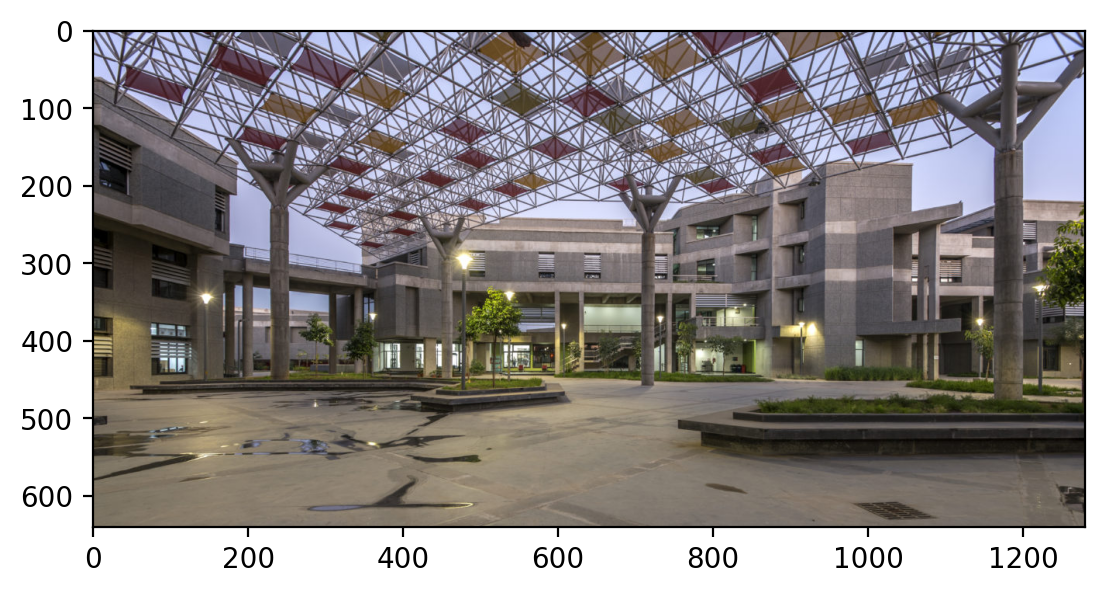

In [6]:
img = torchvision.io.read_image('./iitgn.jpg')
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


### Scale the image to [0,1]

In [7]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [8]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

img_scaled = img_scaled.to(device)
print("Shape of the scaled image:", img_scaled.shape)
img_scaled

Shape of the scaled image: torch.Size([3, 640, 1280])


tensor([[[0.7922, 0.7490, 0.7804,  ..., 0.7451, 0.7647, 0.7569],
         [0.7725, 0.7647, 0.7765,  ..., 0.7490, 0.7529, 0.7451],
         [0.7137, 0.7373, 0.8039,  ..., 0.7412, 0.7490, 0.7451],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.4667, 0.4706, 0.4745],
         [0.4784, 0.4784, 0.4784,  ..., 0.4706, 0.4667, 0.4667],
         [0.4784, 0.4745, 0.4745,  ..., 0.4706, 0.4667, 0.4627]],

        [[0.8392, 0.7922, 0.8039,  ..., 0.8157, 0.8314, 0.8235],
         [0.8353, 0.8118, 0.8078,  ..., 0.8235, 0.8196, 0.8078],
         [0.7804, 0.7961, 0.8471,  ..., 0.8235, 0.8118, 0.7922],
         ...,
         [0.4431, 0.4431, 0.4431,  ..., 0.4314, 0.4353, 0.4392],
         [0.4431, 0.4431, 0.4431,  ..., 0.4353, 0.4314, 0.4314],
         [0.4431, 0.4392, 0.4392,  ..., 0.4353, 0.4314, 0.4275]],

        [[1.0000, 0.9686, 0.9373,  ..., 0.9569, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9608,  ..., 0.9882, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.

### Cropping the Image

torch.Size([3, 300, 300])


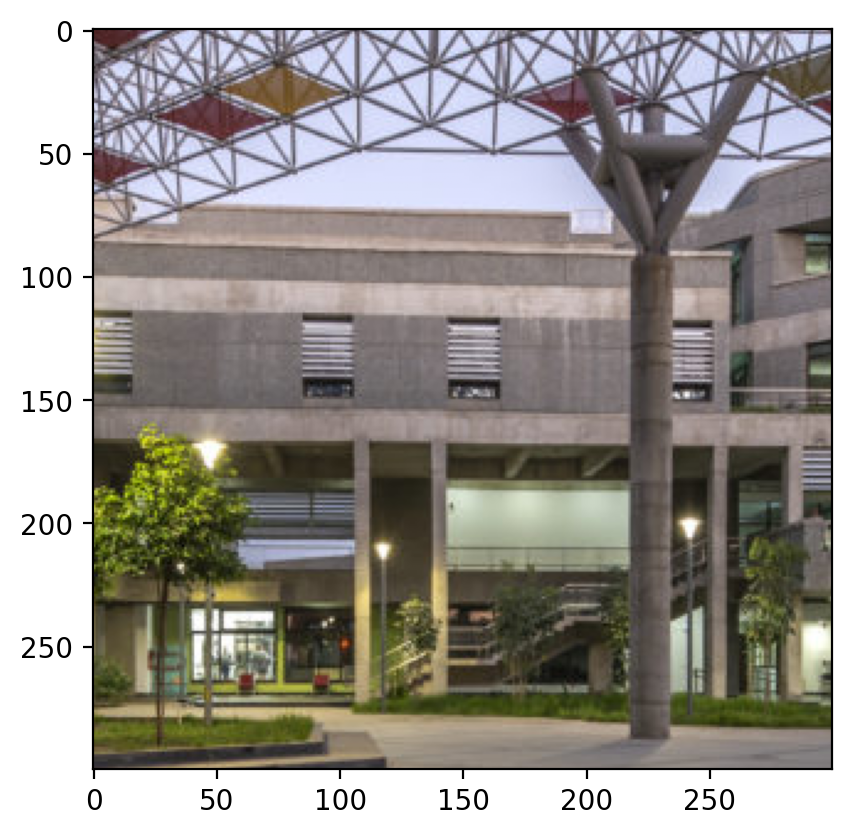

In [9]:
crop = torchvision.transforms.CenterCrop(300)(img_scaled)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

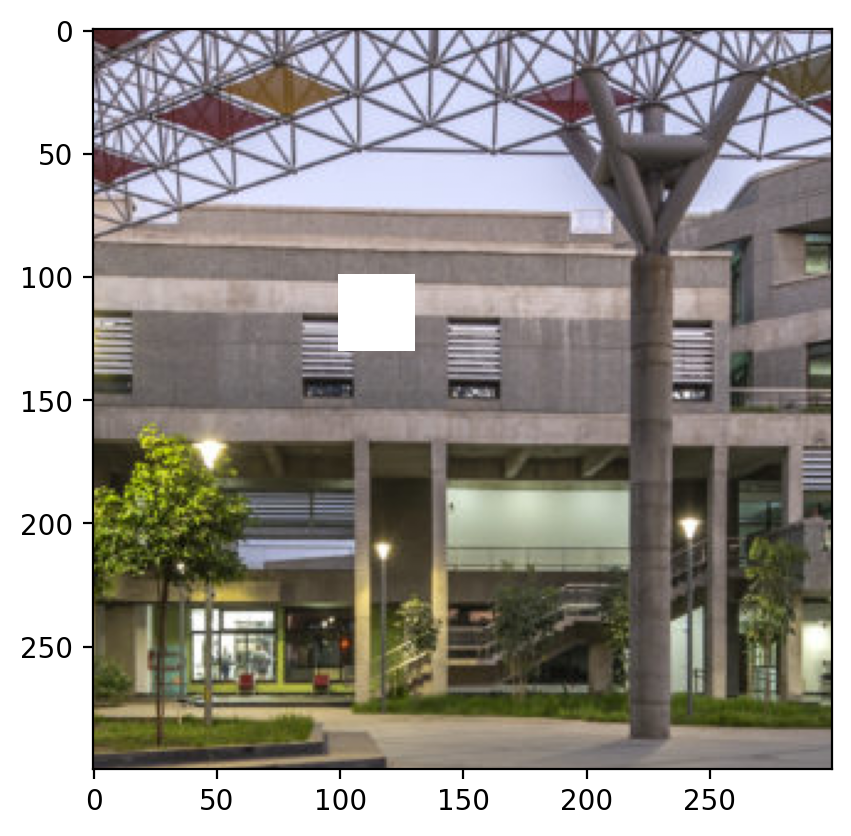

In [115]:

patch_size = 30

C, H, W = crop.shape
top = 100
left = 100


masked_img = crop.clone()

masked_img[:, top:top+patch_size, left:left+patch_size] = float('nan')

plt.imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())


In [121]:
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

def image_reconstruction_rff(img_channel, patch_size, top, left, device, n_components=100, sigma=1.0):
    masked_img = img_channel.clone()
    masked_img[top:top+patch_size, left:left+patch_size] = float('nan')
    

    masked_img_np = masked_img.cpu().numpy().reshape(-1, 1)


    h, w = masked_img.shape
    coords = np.array([[i, j] for i in range(h) for j in range(w)])


    known_mask = ~np.isnan(masked_img_np).flatten()
    known_coords = coords[known_mask]
    known_values = masked_img_np[known_mask]

    print("Shape of known coordinates:", known_coords.shape)
    print("Shape of known values:", known_values.shape)

    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    known_coords_scaled = scaler.fit_transform(known_coords)

    rbf_feature = RBFSampler(n_components=n_components, gamma=1/(2*sigma**2), random_state=42)
    X_rff = rbf_feature.fit_transform(known_coords_scaled)
    print("Shape of RFF features for known coordinates:", X_rff.shape)


    model = Ridge(alpha=1.0, tol=1e-6)
    model.fit(X_rff, known_values)

 
    missing_mask = np.isnan(masked_img_np).flatten()
    missing_coords = coords[missing_mask]
    missing_coords_scaled = scaler.transform(missing_coords)
    X_rff_missing = rbf_feature.transform(missing_coords_scaled)
    predicted_values = model.predict(X_rff_missing)



    predicted_img_np = masked_img_np.copy()
    predicted_img_np[missing_mask, 0] = predicted_values
    predicted_img = predicted_img_np.reshape(h, w)
    predicted_img_tensor = torch.tensor(predicted_img, device=device, dtype=torch.float32)
    return predicted_img_tensor





    
  




In [123]:
print("Reconstructing the image using RFF...")

print("Reconstruction for channel 0 (R):")
reconstructed_img_r = image_reconstruction_rff(crop[0], patch_size, top, left, device, n_components=100, sigma=1.0)

print("Reconstruction for channel 1 (G):")
reconstructed_img_g = image_reconstruction_rff(crop[1], patch_size, top, left, device, n_components=100, sigma=1.0)

print("Reconstruction for channel 2 (B):")
reconstructed_img_b = image_reconstruction_rff(crop[2], patch_size, top, left, device, n_components=100, sigma=1.0)





Reconstructing the image using RFF...
Reconstruction for channel 0 (R):
Shape of known coordinates: (89100, 2)
Shape of known values: (89100, 1)
Shape of RFF features for known coordinates: (89100, 100)
Reconstruction for channel 1 (G):
Shape of known coordinates: (89100, 2)
Shape of known values: (89100, 1)
Shape of RFF features for known coordinates: (89100, 100)
Reconstruction for channel 2 (B):
Shape of known coordinates: (89100, 2)
Shape of known values: (89100, 1)
Shape of RFF features for known coordinates: (89100, 100)


In [125]:
reconstructed_img = torch.stack([reconstructed_img_r, reconstructed_img_g, reconstructed_img_b], dim=0)

print("Shape of the reconstructed image:", reconstructed_img.shape)
print(reconstructed_img)


Shape of the reconstructed image: torch.Size([3, 300, 300])
tensor([[[0.3176, 0.3020, 0.3137,  ..., 0.6314, 0.4549, 0.2824],
         [0.3059, 0.2784, 0.2824,  ..., 0.4824, 0.4980, 0.4118],
         [0.3020, 0.3216, 0.3137,  ..., 0.7882, 0.8000, 0.8000],
         ...,
         [0.1961, 0.1922, 0.1882,  ..., 0.4902, 0.4863, 0.4863],
         [0.2118, 0.2078, 0.2039,  ..., 0.4980, 0.4980, 0.4980],
         [0.2431, 0.2510, 0.2588,  ..., 0.4980, 0.4980, 0.4980]],

        [[0.1529, 0.1373, 0.1569,  ..., 0.5843, 0.4039, 0.2353],
         [0.1451, 0.1137, 0.1255,  ..., 0.4510, 0.4549, 0.3608],
         [0.1529, 0.1647, 0.1569,  ..., 0.7961, 0.8000, 0.7922],
         ...,
         [0.1922, 0.1882, 0.1843,  ..., 0.4745, 0.4706, 0.4706],
         [0.2000, 0.1961, 0.1922,  ..., 0.4824, 0.4824, 0.4824],
         [0.2078, 0.2157, 0.2235,  ..., 0.4824, 0.4824, 0.4824]],

        [[0.1569, 0.1412, 0.1608,  ..., 0.6235, 0.4392, 0.2745],
         [0.1373, 0.1176, 0.1255,  ..., 0.5098, 0.5098, 0.4275]

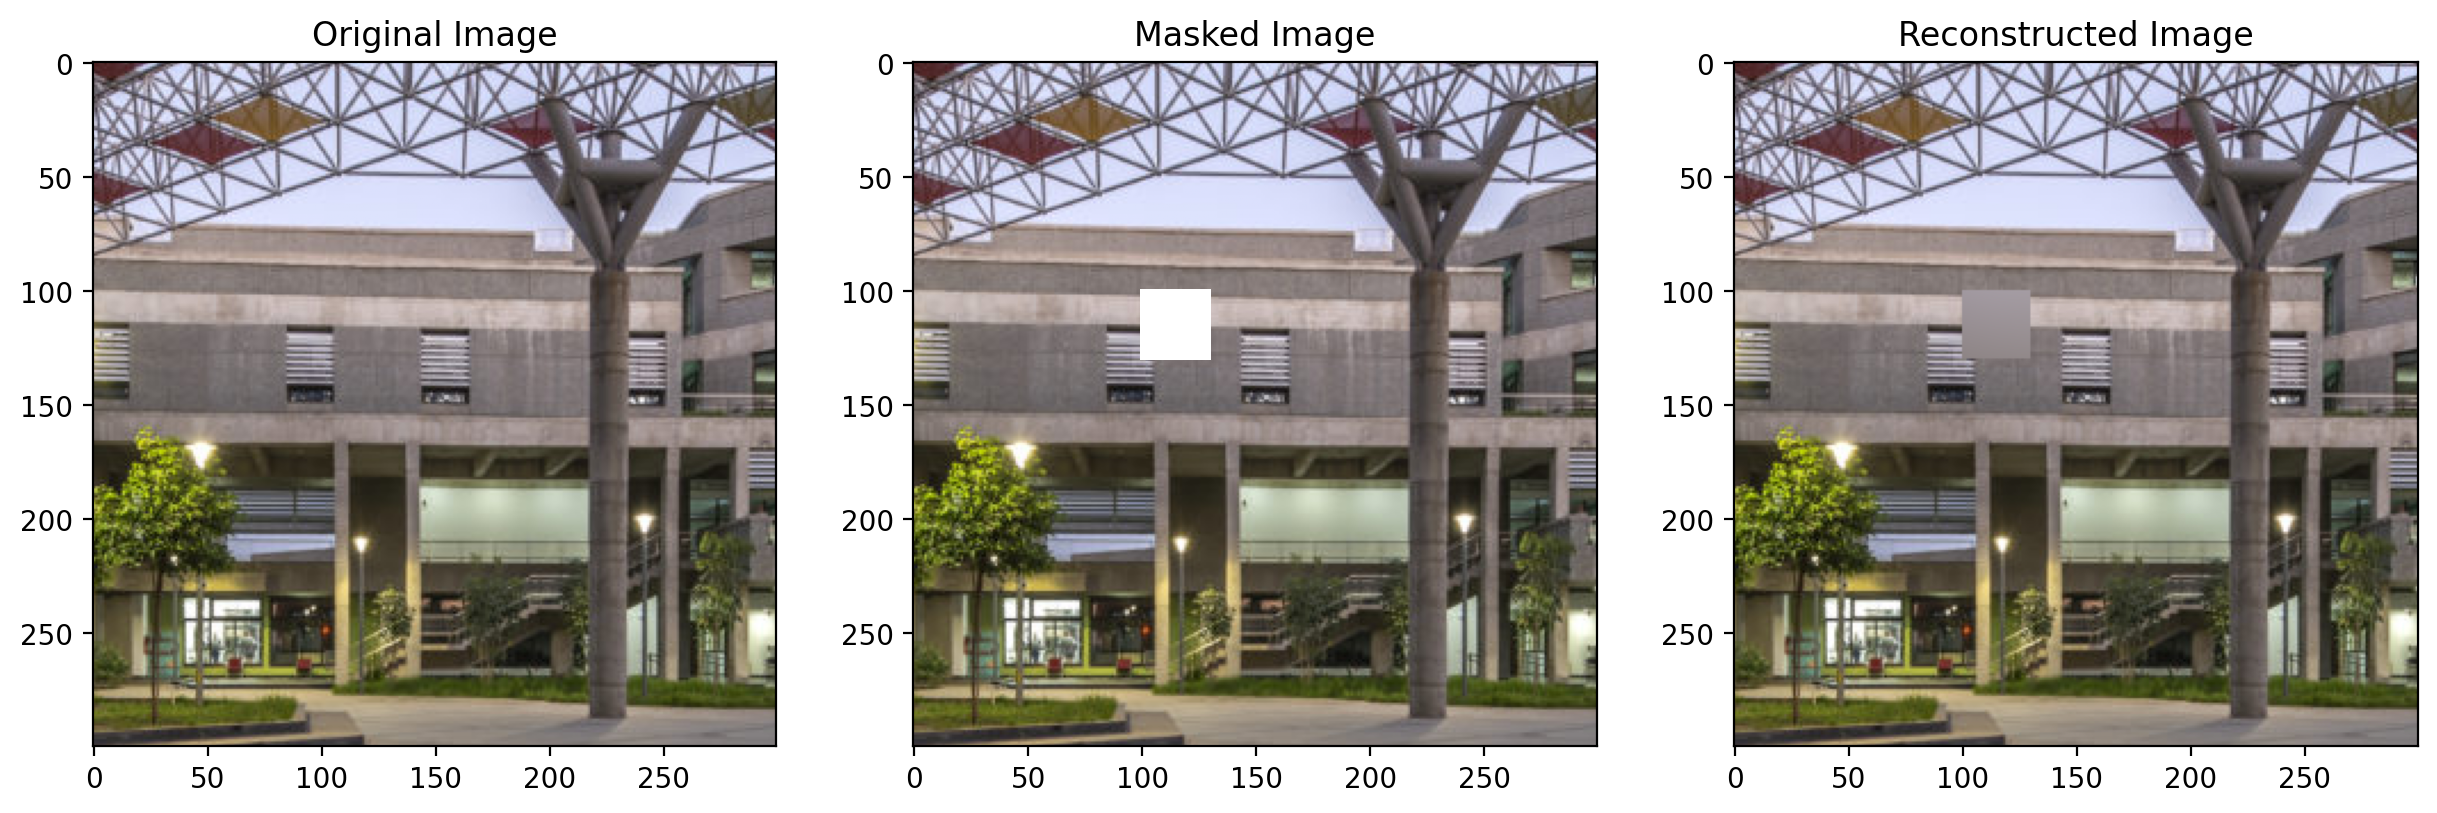

In [127]:
# plot the original image malsed image and the reconstructed image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())
plt.title('Masked Image')
plt.subplot(1, 3, 3)
plt.imshow(rearrange(reconstructed_img, 'c h w -> h w c').cpu().numpy())
plt.title('Reconstructed Image')
plt.show()


In [128]:
def calculate_psnr(original, reconstructed):
    original = original.cpu()
    reconstructed = reconstructed.cpu()
    mse = torch.mean((original - reconstructed) ** 2)
   
    max_pixel = 1.0 
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

def calculate_rmse(original, reconstructed):
    original = original.cpu()
    reconstructed = reconstructed.cpu()
    mse = torch.mean((original - reconstructed) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [130]:
psnr = calculate_psnr(crop, reconstructed_img)
rmse = calculate_rmse(crop, reconstructed_img)

print(f"PSNR: {psnr:.2f} dB")
print(f"RMSE: {rmse:.4f}")

PSNR: 38.05 dB
RMSE: 0.0125
